In [1]:
import pandas as pd
import torch
import torch.nn as nn
import scipy.stats as sps
from scipy.interpolate import interp1d
from torch.utils.data import DataLoader
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from tqdm import tqdm
import seaborn as sns
import os
from typing import List

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
print(device)

cuda:0


In [3]:

class FeedbackDataset:
    def __init__(self, feedback: pd.DataFrame, user_info: pd.DataFrame, item_info: pd.DataFrame):
        self.feedback = feedback
        self.user_info = user_info
        self.item_info = item_info

    def __getitem__(self, idx: int):
        deal = self.feedback.iloc[idx]
        user_features = self.user_info.loc[self.user_info.UserId == deal['UserId']].drop('UserId', axis=1).to_numpy()
        item_features = self.item_info.loc[self.item_info.ItemId == deal['ItemId']].drop('ItemId', axis=1).to_numpy()
        feedback = deal["Feedback"]
        return np.hstack([user_features, item_features])[0], feedback

    def __len__(self) -> int:
        return self.feedback.shape[0]

In [4]:
def usefulness(c, w, noice):
    # return 0.7
    return np.arctan(c - w + noice) / np.pi + 0.5


customer_distribution = sps.norm(0.6, 0.2)
w_distribution = sps.norm(0, 0.4)

epsilon = sps.norm(0, 0.05)


class Distribution_Handler:
    def __init__(self, distribution):
        self.distribution = distribution

    def rvs(self, size=1):
        if issubclass(type(self.distribution), sps.rv_continuous):
            return self.distribution.rvs(size)
        else:
            return self.distribution.resample(size)[0]

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_shape=2, num_classes=2):
        super(self.__class__, self).__init__()
        self.ratings = []
        self.model = nn.Sequential(
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Sigmoid(),
            nn.Linear(256, 32),
            nn.Sigmoid(),
            nn.Linear(32, num_classes),
            nn.Sigmoid(),
        )

    def get_interacted_items(self, user_id):
        return self.ratings.loc[self.ratings.UserId == user_id]['ItemId'].unique()

    def recommend_topN(self, user_info, items_to_recommend, topn=10):
        with torch.no_grad():
            n = min(topn, len(items_to_recommend.index))
            features = items_to_recommend["F"].to_numpy()
            x = np.vstack((np.array([user_info["F"]] * len(features)), features)).T
            x = (torch.from_numpy(x)).type(torch.FloatTensor).to(device)
            y_pred = self.__call__(x)[:, 1]

            res = torch.topk(y_pred, k=n)
            return pd.DataFrame({"ItemId": res.indices.cpu().numpy(), "Rating": res.values.cpu().numpy()})

    def forward(self, inp):
        out = self.model(inp)
        return out

In [6]:
def fit_epoch(model, optimizer, loss_function, loader):
    model.train()
    processed_size = 0
    cumulative_loss = 0.0
    correct = 0

    for x_batch, y_batch in loader:
        x_batch = x_batch.type(torch.FloatTensor).to(device)
        y_batch = y_batch.type(torch.FloatTensor).to(device)
        optimizer.zero_grad()

        y_pred = model(x_batch)
        loss = loss_function.forward(y_pred[:, 1], y_batch)
        loss.backward()

        optimizer.step()
        cumulative_loss += loss
        processed_size += x_batch.shape[0]
        correct += torch.sum(torch.argmax(y_pred, dim=1) == y_batch)

    return cumulative_loss.item() / processed_size, correct.item() / processed_size

In [7]:
def eval_epoch(model, loss_function, loader):
    model.eval()
    processed_size = 0
    cumulative_loss = 0.0
    correct = 0
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.type(torch.FloatTensor).to(device)
            y_batch = y_batch.type(torch.FloatTensor).to(device)

            y_pred = model(x_batch)
            loss = loss_function.forward(y_pred[:, 1], y_batch)

            cumulative_loss += loss
            processed_size += len(x_batch)
            correct += torch.sum(torch.argmax(y_pred, dim=1) == y_batch)

    return cumulative_loss.item() / processed_size, correct.item() / processed_size

In [8]:
def print_distributions(num_of_iteration, axs, user_info, item_info):
    sns.kdeplot(user_info["F"], ax=axs[0], label=f"Itration number = {num_of_iteration}")
    axs[0].set_title("User Distribution")
    sns.kdeplot(data=item_info["F"], ax=axs[1])
    axs[1].set_title("Item Distribution")

In [9]:


def rosenblatt_test(x, y, alpha=0.05):
    rosenblatt_quantiles = {0.5: 0.12, 0.85: 0.28, 0.9: 0.35, 0.95: 0.46, 0.975: 0.58, 0.99: 0.74}
    x = np.sort(x)
    y = np.sort(y)
    all_samples = np.hstack((x, y))

    n = len(x)
    m = len(y)

    variational = sps.rankdata(all_samples, method='ordinal')

    R = variational[:n]
    S = variational[n:]

    z = (1.0 / (n + m)) * (
            1.0 / 6 + np.sum((R - np.arange(1, n + 1)) ** 2) / m + np.sum((S - np.arange(1, m + 1)) ** 2) / n) - (
                2 * n * m / (3 * (n + m)))

    expected_z = (1 + 1 / (n + m)) / 6
    variance_z = (1 + 1 / (n + m) - 3 * (n + m) / (4 * n * m)) * (1 + 1 / (n + m)) / 45

    return (z - expected_z) / np.sqrt(variance_z * 45) + 1 / 6, rosenblatt_quantiles[1 - alpha]

In [10]:
def interpol_distribution(sample, bins=100):
    hst = np.histogram(sample, density=True, bins=bins)
    return interp1d(hst[1][:-1], hst[0], kind='linear', fill_value=0.0, bounds_error=False)

In [71]:
def dynamic_system_iterate(model, loss_function, optimizer, customer_distribution, w_distribution, c_size=8, w_size=8,
                           num_of_steps=5, topn=8,
                           delta=1e-4, visualize_distributions=None):
    user_info = pd.DataFrame(
        {"F": customer_distribution.rvs(size=c_size)})  # size = (c_size, c_feature_size) в многомерном случае 
    user_info["UserId"] = np.arange(c_size)

    item_info = pd.DataFrame(
        {"F": w_distribution.rvs(size=w_size)})  # size = (w_size, w_feature_size) в многомерном случае 
    item_info["ItemId"] = np.arange(w_size)

    if visualize_distributions is not None:
        print_distributions(visualize_distributions[0], visualize_distributions[1], user_info, item_info)

    predicted_feedback_1 = []
    predicted_feedback_2 = []
    real_feedback = []

    diff_feedback = []

    for step in range(1, num_of_steps + 1):
        for index, user_row in user_info.iterrows():
            w_offered = model.recommend_topN(user_row, item_info, topn=topn)
            cur_diff_feadback = []
            predicted_cur_match_1 = []
            predicted_cur_match_2 = []
            for _, w in w_offered.iterrows():
                feature = item_info.loc[item_info.ItemId == w.ItemId]["F"]
                real_deal = sps.bernoulli.rvs(usefulness(user_row["F"], feature, epsilon.rvs()))  # моделируем сделки
                real_feedback.append((user_row["UserId"], w["ItemId"], real_deal))

                predicted_deal_1 = 1 if w["Rating"] >= 0.5 else 0
                predicted_deal_2 = sps.bernoulli.rvs(w["Rating"])
                predicted_cur_match_1.append(1 if predicted_deal_1==real_deal else 0)
                predicted_cur_match_2.append(1 if predicted_deal_2==real_deal else 0)
                cur_diff_feadback.append(w["Rating"] - usefulness(user_row["F"], feature, epsilon.rvs()))
            diff_feedback.append(np.array(cur_diff_feadback).mean())
            predicted_feedback_1.append(np.array(predicted_cur_match_1).mean())
            predicted_feedback_2.append(np.array(predicted_cur_match_2).mean())


    new_feedback_df = pd.DataFrame(real_feedback, columns=['UserId', 'ItemId', 'Feedback'])

    batch_size = 512
    train_dataset = FeedbackDataset(new_feedback_df, user_info, item_info)
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # loss = None
    # if model.__class__.__name__ != "Oracle":
    loss, accuracy = eval_epoch(model, loss_function, train_data_loader)
    #     fit_epoch(model, optimizer, loss_function, train_data_loader)
    # else:
    #     loss = 0

    grouped_users = new_feedback_df.groupby('UserId')['Feedback'].mean().reset_index()
    grouped_users['Feedback'] += 1 / topn

    user_info = user_info.merge(grouped_users, how="inner", on='UserId')
    customer_distribution = Distribution_Handler(
        sps.gaussian_kde(user_info["F"], bw_method=.1, weights=user_info['Feedback']))
    # sps.gaussian_kde(user_info["F"], weights=user_info['Feedback']))

    grouped_items = new_feedback_df.groupby('ItemId')['Feedback'].mean().reset_index()

    item_info = item_info.merge(grouped_items, how="left", on='ItemId').fillna(0)
    item_info['Feedback'] += delta

    w_distribution = Distribution_Handler(
        sps.gaussian_kde(item_info["F"], bw_method=.1, weights=item_info['Feedback']))
        # sps.gaussian_kde(item_info["F"], weights=item_info['Feedback']))
    return customer_distribution, w_distribution, (np.array(predicted_feedback_1).mean(), np.array(predicted_feedback_2).mean()), np.array(diff_feedback).mean()




In [72]:
start_c_size = 128
start_w_size = 128

user_info = pd.DataFrame({"F": customer_distribution.rvs(size=start_c_size)})  # генерим датасет для нулевой итерации
user_info["UserId"] = np.arange(start_c_size)

item_info = pd.DataFrame({"F": w_distribution.rvs(size=start_w_size)})
item_info["ItemId"] = np.arange(start_w_size)
feedback = []

for i, user_row in user_info.iterrows():
    for j, item_row in item_info.iterrows():
        deal = sps.bernoulli.rvs(usefulness(user_row["F"], item_row["F"], epsilon.rvs()))
        feedback.append((user_row["UserId"], item_row["ItemId"], deal))
feedback = pd.DataFrame(feedback, columns=['UserId', 'ItemId', 'Feedback'])
batch_size = 512
train_dataset = FeedbackDataset(feedback, user_info, item_info)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [73]:
model = NeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999))
loss_func = torch.nn.BCELoss()
loss, _ = fit_epoch(model, opt, loss_func, train_data_loader)
# loss_history.append(loss)

100%|██████████| 101/101 [04:57<00:00,  2.95s/it]
/tmp/ipykernel_6177/3854523709.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


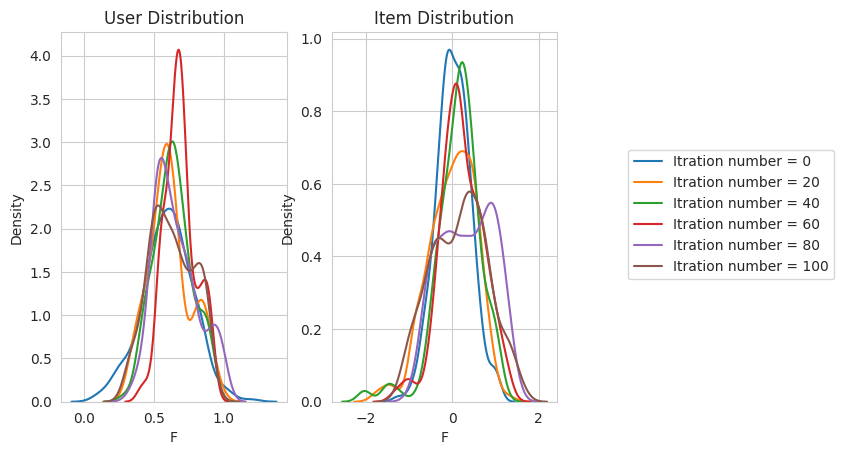

In [74]:
new_cust_distr, new_w_distr = customer_distribution, w_distribution
loss_history = []
residual_history = []
c_size = 256
w_size = 512
big_steps = 101
fig, axs = plt.subplots(ncols=2)
for i in tqdm(range(big_steps)):
    if i % 20 == 0:
        new_cust_distr, new_w_distr, loss, residual = dynamic_system_iterate(model, loss_func, opt, new_cust_distr,
                                                                             new_w_distr,
                                                                             c_size=c_size,
                                                                             w_size=w_size, num_of_steps=1, delta=1e10,
                                                                             visualize_distributions=(i, axs))
    else:
        new_cust_distr, new_w_distr, loss, residual = dynamic_system_iterate(model, loss_func, opt, new_cust_distr,
                                                                             new_w_distr,
                                                                             c_size=c_size,
                                                                             w_size=w_size, delta=1e10, num_of_steps=1)
    loss_history.append(loss)
    residual_history.append(residual)
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.show()

In [75]:
loss_history = np.array(loss_history).T

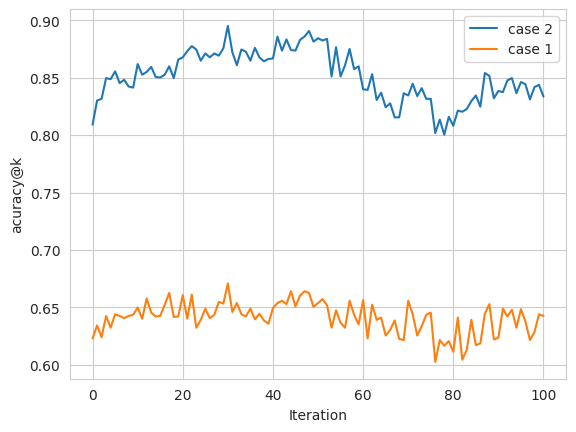

In [76]:

plt.plot(np.arange(big_steps), loss_history[0], label="case 2")
plt.plot(np.arange(big_steps), loss_history[1], label="case 1")

plt.xlabel("Iteration")
plt.ylabel("acuracy@k")
plt.legend()
plt.show()

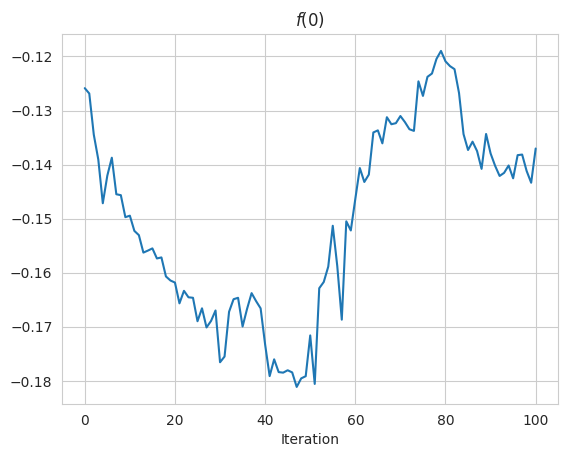

In [77]:
plt.plot(np.arange(big_steps), residual_history)
plt.xlabel("Iteration")
plt.title(r"$f(0)$")
# plt.title(r"$\frac{real \  feedback - predicted \ feedback} {num \ of \ predictions}$")
plt.show()

In [70]:
class Oracle:
    def recommend_topN(self, user_info, items_to_recommend, topn=10):
        n = min(topn, items_to_recommend.shape[0])
        res = np.array([usefulness(user_info["F"], items_to_recommend["F"].to_numpy(),
                                   epsilon.rvs(items_to_recommend.shape[0]))] * n)
        ids = np.argpartition(res, n - 1)
        return pd.DataFrame({"ItemId": ids[:n], "Rating": res[ids][:n]})

In [93]:
model = Oracle()

In [94]:
start_c_size = 128
start_w_size = 128

user_info = pd.DataFrame({"F": customer_distribution.rvs(size=start_c_size)})  # генерим датасет для нулевой итерации
user_info["UserId"] = np.arange(start_c_size)

item_info = pd.DataFrame({"F": w_distribution.rvs(size=start_w_size)})
item_info["ItemId"] = np.arange(start_w_size)
feedback = []

for i, user_row in user_info.iterrows():
    for j, item_row in item_info.iterrows():
        deal = sps.bernoulli.rvs(usefulness(user_row["F"], item_row["F"], epsilon.rvs()))
        feedback.append((user_row["UserId"], item_row["ItemId"], deal))
feedback = pd.DataFrame(feedback, columns=['UserId', 'ItemId', 'Feedback'])
batch_size = 512
train_dataset = FeedbackDataset(feedback, user_info, item_info)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/51 [00:00<?, ?it/s]

-1.203972804325936 0 0.7
-1.203972804325936 0 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
-1.203972804325936 0 0.7
0.35667494393873245 1 0.7
-1.203972804325936 0 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
-1.203972804325936 0 0.7
-1.203972804325936 0 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
-1.203972804325936 0 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
-1.203972804325936 0 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
-1.203972804325936 0 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
-1.203972804325936 0 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 

  2%|▏         | 1/51 [00:00<00:37,  1.32it/s]

0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
-1.203972804325936 0 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
-1.203972804325936 0 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
-1.203972804325936 0 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
-1.203972804325936 0 0.7
-1.203972804325936 0 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
-1.203972804325936 0 0.7
0.35667494393873245 1 0.7
-1.203972804325936 0 0.7
-1.203972804325936 0 0.7
0.35667494393873245 1 0.7
-1.203972804325936 0 0.7
-1.203972804325936 0 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 

  4%|▍         | 2/51 [00:01<00:36,  1.35it/s]

0.35667494393873245 1 0.7
-1.203972804325936 0 0.7
-1.203972804325936 0 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
-1.203972804325936 0 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
-1.203972804325936 0 0.7
0.35667494393873245 1 0.7
-1.203972804325936 0 0.7
0.35667494393873245 1 0.7
-1.203972804325936 0 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
-1.203972804325936 0 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
-1.203972804325936 0 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
-1.203972804325936 0 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
-1.203972804325936 0 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 

  4%|▍         | 2/51 [00:02<00:54,  1.10s/it]

0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
-1.203972804325936 0 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
-1.203972804325936 0 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
-1.203972804325936 0 0.7
0.35667494393873245 1 0.7
-1.203972804325936 0 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
-1.203972804325936 0 0.7
-1.203972804325936 0 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
0.35667494393873245 1 0.7
-1.203972804325936 0 0.7
-1.203972804325936 0 0.7
-1.203972804325936 0 0.7
-1.203972804325936 0 0.7
0.35667494393873245 1 0.7
-1.203972804325936 0 0.7
0.35667494393873245 1 0

KeyboardInterrupt: 

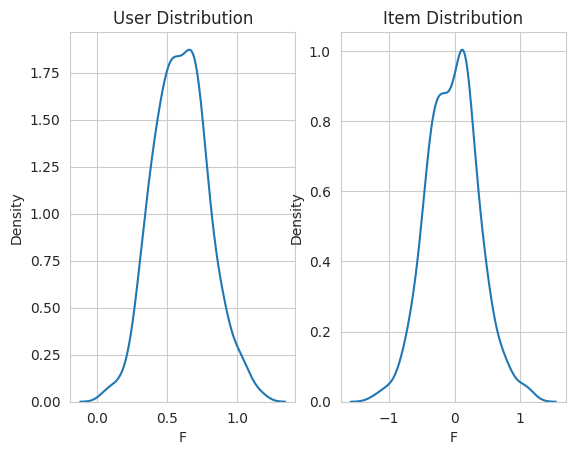

In [95]:
new_cust_distr, new_w_distr = customer_distribution, w_distribution
c_size = 512
w_size = 512
big_steps = 51
fig, axs = plt.subplots(ncols=2)
residual_history = []
for i in tqdm(range(big_steps)):
    if i % 5 == 0:
        new_cust_distr, new_w_distr, _, residual = dynamic_system_iterate(model, loss_func, opt, new_cust_distr,
                                                                          new_w_distr,
                                                                          c_size=c_size,
                                                                          w_size=w_size, num_of_steps=1, delta=1e3,
                                                                          visualize_distributions=(i, axs))
    else:
        new_cust_distr, new_w_distr, _, residual = dynamic_system_iterate(model, loss_func, opt, new_cust_distr,
                                                                          new_w_distr,
                                                                          c_size=c_size,
                                                                          w_size=w_size, delta=1e3, num_of_steps=1)
    residual_history.append(residual)
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.show()

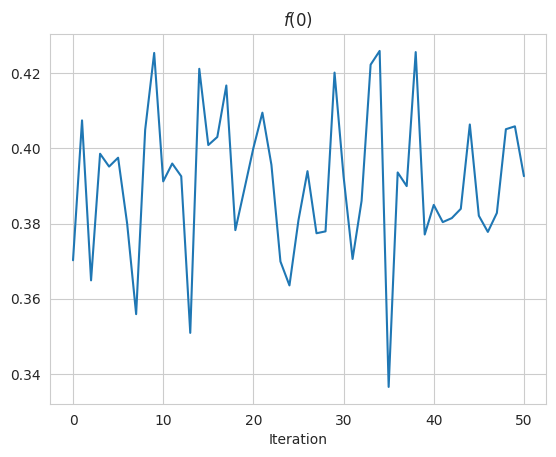

In [87]:
# plt.plot(np.arange(big_steps), loss_history)
# plt.xlabel("Iteration")
# plt.ylabel("Logloss")
# plt.show()
plt.plot(np.arange(big_steps), residual_history[-big_steps:])
plt.xlabel("Iteration")
plt.title(r"$f(0)$")
# plt.title(r"$\frac{real \  feedback - predicted \ feedback} {num \ of \ predictions}$")
plt.show()

In [19]:
x = np.array([1, 1, 1, 1])
np.argpartition(x, 3)

array([1, 0, 2, 3])